In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
import sys
sys.path.extend(["..", "../../backbone","../.."])
from densenet201 import DenseNet201
from resnet152d import ResNet152d
from focal import FocalLoss
from dataloader import create_dataloader
from metric import Metric
from ctran import CTranEncoder2
torch.cuda.empty_cache()
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score
from tabulate import tabulate
# from torchsummary import summary

# Set device to GPU if available, else use CPU
device = torch.device("cuda")
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")

Current device: NVIDIA RTX A6000


In [2]:
# Define hyperparameters
batch_size = 12
num_epochs = 200
learning_rate = 0.000001
image_size = 384
num_workers = 8
num_labels = 20
num_layers = 6
embed_dim = 960
mlp_dim = 1024
thresholds = [0.5] * num_labels
num_classes = 20
data_dir = '../../../mured-data/data'

In [3]:
# Create dataloaders
train_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='train')
val_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='val')

384
384


In [4]:
# Define model and optimizer
backbone1 = DenseNet201(num_classes=num_classes, embed_dim=embed_dim)
backbone2 = ResNet152d(num_classes=num_classes, embed_dim=embed_dim)
model = CTranEncoder2(num_classes=num_classes, embed_dim=embed_dim, num_layers=num_layers, num_heads=num_workers, 
                       backbone1=backbone1, backbone2=backbone2)
model.to(device)

# Wrap your model with DataParallel
# model = nn.DataParallel(model, device_ids=[0, 1, 2, 3])
criterion = nn.BCEWithLogitsLoss()
# criterion = FocalLoss(gamma=2, alpha=0.25, reduction='mean')

# Create a single optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-6)

# Create a single scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, epochs= num_epochs, steps_per_epoch=len(train_dataloader))

/home/deependra/project/rfmidc/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deependra/project/rfmidc/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([960, 384, 384])


In [5]:
# Initialize Metric class
metric = Metric(num_classes=num_classes)

# create empty lists to store predicted probabilities and true labels for each epoch
val_preds_all, val_labels_all = [], []

# define the epochs at which to plot the ROC curve
roc_epochs = [5,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]

# create empty lists to store ROC data for each epoch
roc_fpr = []
roc_tpr = []
roc_auc = []
f1_arr = []
loss_arr = []
model_arr = []
max_ms = [0,0,0]
a,b = 0.4,0.6

# Train and evaluate model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    # Train phase
    model.train()
    optimizer.zero_grad()
    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels) 
        outputs = torch.sigmoid(outputs)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        # Compute metrics on train set
        with torch.no_grad():
            metric.update(outputs, labels,0)
    
    # Print metrics on train set 1
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric.compute(1)
    print("DenseNet201:\n",f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
    
    # Reset Metric class for evaluation
    metric.reset()
    del images
    del labels
    del outputs
    torch.cuda.empty_cache() 

    # Evaluate model on validation set
    model.eval()
    running_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels) 
            outputs = torch.sigmoid(outputs)

            # Calculate weighted average loss
            running_loss += loss.item()
            
            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            val_preds += outputs.tolist()
            val_labels += labels.tolist()
            metric.update(outputs, labels, 1)

 
        # Print metrics on validation set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric.compute(0)
        print(f"Val - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        f1_arr.append(ml_f1_score)
        model_arr.append(model_score)
        loss_arr.append(running_loss / len(val_dataloader))
        
        if max_ms[0] < model_score: 
            max_ms[0] = model_score
            max_ms[1] = epoch
            max_ms[2] = optimizer.param_groups[0]['lr']

        # append the predicted probabilities and true labels for this epoch to the lists for all epochs
        val_preds_all.append(val_preds)
        val_labels_all.append(val_labels)

        # check if the current epoch is in the list of epochs to plot ROC curve
        if epoch+1 in roc_epochs:
            # calculate ROC curve and AUC score for validation set
            fpr, tpr, roc_thresholds = roc_curve(np.concatenate(val_labels_all).ravel(), np.concatenate(val_preds_all).ravel())
            roc_fpr.append(fpr)
            roc_tpr.append(tpr)
            roc_auc.append(auc(fpr, tpr))

        print() # empty line for spacing    
        
        # Reset Metric class for next epoch
        metric.reset()
        del images
        del labels
        del outputs
        torch.cuda.empty_cache()   
    
    # Step the learning rate scheduler
    scheduler.step()     

Epoch 1/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.20it/s]


DenseNet201:
 Epoch [1/200], Loss: 0.2329, ML mAP: 0.1899, ML F1: 0.0745, ML AUC: 0.7104, ML Score: 0.4501, Bin AUC: 0.6389, Model Score: 0.5445, Bin F1: 0.2500


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Val - Epoch [1/200], Loss: 0.2260, ML mAP: 0.3600, ML F1: 0.1112, ML AUC: 0.8636, ML Score: 0.6118, Bin AUC: 0.6316, Model Score: 0.6217, Bin F1: 0.0000

Epoch 2/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [2/200], Loss: 0.2099, ML mAP: 0.4017, ML F1: 0.2792, ML AUC: 0.8592, ML Score: 0.6304, Bin AUC: 0.6842, Model Score: 0.6573, Bin F1: 0.0000


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Val - Epoch [2/200], Loss: 0.1894, ML mAP: 0.4970, ML F1: 0.3365, ML AUC: 0.9026, ML Score: 0.6998, Bin AUC: 0.8947, Model Score: 0.7973, Bin F1: 0.0000

Epoch 3/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [3/200], Loss: 0.1106, ML mAP: 0.5710, ML F1: 0.4663, ML AUC: 0.9148, ML Score: 0.7429, Bin AUC: 0.9167, Model Score: 0.8298, Bin F1: 0.4000


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Val - Epoch [3/200], Loss: 0.1441, ML mAP: 0.5596, ML F1: 0.4525, ML AUC: 0.9221, ML Score: 0.7409, Bin AUC: 0.8947, Model Score: 0.8178, Bin F1: 0.0000

Epoch 4/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [4/200], Loss: 0.1418, ML mAP: 0.6929, ML F1: 0.6025, ML AUC: 0.9423, ML Score: 0.8176, Bin AUC: 1.0000, Model Score: 0.9088, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Val - Epoch [4/200], Loss: 0.1467, ML mAP: 0.5969, ML F1: 0.5293, ML AUC: 0.9229, ML Score: 0.7599, Bin AUC: 1.0000, Model Score: 0.8799, Bin F1: 0.0000

Epoch 5/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [5/200], Loss: 0.1415, ML mAP: 0.7844, ML F1: 0.6997, ML AUC: 0.9587, ML Score: 0.8715, Bin AUC: 0.8889, Model Score: 0.8802, Bin F1: 0.0000


100%|██████████| 37/37 [00:05<00:00,  6.39it/s]


Val - Epoch [5/200], Loss: 0.1532, ML mAP: 0.5892, ML F1: 0.5124, ML AUC: 0.9218, ML Score: 0.7555, Bin AUC: 1.0000, Model Score: 0.8778, Bin F1: 0.0000

Epoch 6/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [6/200], Loss: 0.0901, ML mAP: 0.8281, ML F1: 0.7540, ML AUC: 0.9711, ML Score: 0.8996, Bin AUC: 0.7895, Model Score: 0.8445, Bin F1: 0.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [6/200], Loss: 0.1445, ML mAP: 0.6117, ML F1: 0.5180, ML AUC: 0.9288, ML Score: 0.7702, Bin AUC: 0.9474, Model Score: 0.8588, Bin F1: 0.0000

Epoch 7/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [7/200], Loss: 0.0927, ML mAP: 0.8790, ML F1: 0.8151, ML AUC: 0.9812, ML Score: 0.9301, Bin AUC: 0.9474, Model Score: 0.9387, Bin F1: 0.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [7/200], Loss: 0.1361, ML mAP: 0.6321, ML F1: 0.5523, ML AUC: 0.9330, ML Score: 0.7826, Bin AUC: 1.0000, Model Score: 0.8913, Bin F1: 1.0000

Epoch 8/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [8/200], Loss: 0.1045, ML mAP: 0.9155, ML F1: 0.8470, ML AUC: 0.9873, ML Score: 0.9514, Bin AUC: 1.0000, Model Score: 0.9757, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [8/200], Loss: 0.1499, ML mAP: 0.6380, ML F1: 0.5917, ML AUC: 0.9296, ML Score: 0.7838, Bin AUC: 1.0000, Model Score: 0.8919, Bin F1: 1.0000

Epoch 9/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [9/200], Loss: 0.0551, ML mAP: 0.9284, ML F1: 0.8609, ML AUC: 0.9903, ML Score: 0.9593, Bin AUC: 1.0000, Model Score: 0.9797, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Val - Epoch [9/200], Loss: 0.1556, ML mAP: 0.6470, ML F1: 0.5832, ML AUC: 0.9271, ML Score: 0.7871, Bin AUC: 1.0000, Model Score: 0.8935, Bin F1: 1.0000

Epoch 10/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [10/200], Loss: 0.0552, ML mAP: 0.9280, ML F1: 0.8681, ML AUC: 0.9878, ML Score: 0.9579, Bin AUC: 1.0000, Model Score: 0.9789, Bin F1: 0.8000


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Val - Epoch [10/200], Loss: 0.1449, ML mAP: 0.6444, ML F1: 0.5834, ML AUC: 0.9276, ML Score: 0.7860, Bin AUC: 1.0000, Model Score: 0.8930, Bin F1: 1.0000

Epoch 11/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [11/200], Loss: 0.0464, ML mAP: 0.8505, ML F1: 0.7756, ML AUC: 0.9756, ML Score: 0.9130, Bin AUC: 0.9474, Model Score: 0.9302, Bin F1: 0.0000


100%|██████████| 37/37 [00:05<00:00,  6.39it/s]


Val - Epoch [11/200], Loss: 0.1916, ML mAP: 0.5888, ML F1: 0.5164, ML AUC: 0.9224, ML Score: 0.7556, Bin AUC: 0.8421, Model Score: 0.7989, Bin F1: 0.0000

Epoch 12/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [12/200], Loss: 0.0256, ML mAP: 0.8521, ML F1: 0.7880, ML AUC: 0.9751, ML Score: 0.9136, Bin AUC: 1.0000, Model Score: 0.9568, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [12/200], Loss: 0.1870, ML mAP: 0.6348, ML F1: 0.5678, ML AUC: 0.9257, ML Score: 0.7803, Bin AUC: 1.0000, Model Score: 0.8901, Bin F1: 1.0000

Epoch 13/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [13/200], Loss: 0.0805, ML mAP: 0.8807, ML F1: 0.8108, ML AUC: 0.9796, ML Score: 0.9302, Bin AUC: 1.0000, Model Score: 0.9651, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [13/200], Loss: 0.1654, ML mAP: 0.6181, ML F1: 0.5589, ML AUC: 0.9253, ML Score: 0.7717, Bin AUC: 1.0000, Model Score: 0.8858, Bin F1: 1.0000

Epoch 14/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [14/200], Loss: 0.0379, ML mAP: 0.9026, ML F1: 0.8395, ML AUC: 0.9860, ML Score: 0.9443, Bin AUC: 1.0000, Model Score: 0.9721, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.39it/s]


Val - Epoch [14/200], Loss: 0.1972, ML mAP: 0.6240, ML F1: 0.5729, ML AUC: 0.9228, ML Score: 0.7734, Bin AUC: 1.0000, Model Score: 0.8867, Bin F1: 1.0000

Epoch 15/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [15/200], Loss: 0.0254, ML mAP: 0.9142, ML F1: 0.8574, ML AUC: 0.9865, ML Score: 0.9504, Bin AUC: 1.0000, Model Score: 0.9752, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [15/200], Loss: 0.1768, ML mAP: 0.6289, ML F1: 0.5646, ML AUC: 0.9339, ML Score: 0.7814, Bin AUC: 1.0000, Model Score: 0.8907, Bin F1: 1.0000

Epoch 16/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [16/200], Loss: 0.0820, ML mAP: 0.9350, ML F1: 0.8743, ML AUC: 0.9906, ML Score: 0.9628, Bin AUC: 1.0000, Model Score: 0.9814, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [16/200], Loss: 0.1674, ML mAP: 0.6214, ML F1: 0.5795, ML AUC: 0.9304, ML Score: 0.7759, Bin AUC: 1.0000, Model Score: 0.8879, Bin F1: 1.0000

Epoch 17/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [17/200], Loss: 0.0226, ML mAP: 0.9452, ML F1: 0.8923, ML AUC: 0.9919, ML Score: 0.9685, Bin AUC: 1.0000, Model Score: 0.9843, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Val - Epoch [17/200], Loss: 0.1942, ML mAP: 0.6415, ML F1: 0.5864, ML AUC: 0.9307, ML Score: 0.7861, Bin AUC: 1.0000, Model Score: 0.8931, Bin F1: 1.0000

Epoch 18/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [18/200], Loss: 0.0410, ML mAP: 0.9494, ML F1: 0.9071, ML AUC: 0.9927, ML Score: 0.9710, Bin AUC: 0.9722, Model Score: 0.9716, Bin F1: 0.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [18/200], Loss: 0.1807, ML mAP: 0.6615, ML F1: 0.6176, ML AUC: 0.9274, ML Score: 0.7944, Bin AUC: 1.0000, Model Score: 0.8972, Bin F1: 1.0000

Epoch 19/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [19/200], Loss: 0.0413, ML mAP: 0.9522, ML F1: 0.9120, ML AUC: 0.9923, ML Score: 0.9722, Bin AUC: 1.0000, Model Score: 0.9861, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [19/200], Loss: 0.1759, ML mAP: 0.6590, ML F1: 0.5983, ML AUC: 0.9220, ML Score: 0.7905, Bin AUC: 1.0000, Model Score: 0.8952, Bin F1: 0.6667

Epoch 20/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [20/200], Loss: 0.0281, ML mAP: 0.9722, ML F1: 0.9262, ML AUC: 0.9960, ML Score: 0.9841, Bin AUC: 1.0000, Model Score: 0.9921, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Val - Epoch [20/200], Loss: 0.2327, ML mAP: 0.6587, ML F1: 0.6239, ML AUC: 0.9203, ML Score: 0.7895, Bin AUC: 1.0000, Model Score: 0.8948, Bin F1: 1.0000

Epoch 21/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [21/200], Loss: 0.0185, ML mAP: 0.9663, ML F1: 0.9255, ML AUC: 0.9956, ML Score: 0.9810, Bin AUC: 1.0000, Model Score: 0.9905, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [21/200], Loss: 0.1890, ML mAP: 0.6603, ML F1: 0.6140, ML AUC: 0.9300, ML Score: 0.7951, Bin AUC: 1.0000, Model Score: 0.8976, Bin F1: 1.0000

Epoch 22/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [22/200], Loss: 0.0300, ML mAP: 0.9774, ML F1: 0.9448, ML AUC: 0.9975, ML Score: 0.9874, Bin AUC: 1.0000, Model Score: 0.9937, Bin F1: 0.6667


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [22/200], Loss: 0.1983, ML mAP: 0.6696, ML F1: 0.6157, ML AUC: 0.9254, ML Score: 0.7975, Bin AUC: 1.0000, Model Score: 0.8987, Bin F1: 1.0000

Epoch 23/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [23/200], Loss: 0.0176, ML mAP: 0.9758, ML F1: 0.9427, ML AUC: 0.9972, ML Score: 0.9865, Bin AUC: 1.0000, Model Score: 0.9932, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [23/200], Loss: 0.1781, ML mAP: 0.6639, ML F1: 0.6344, ML AUC: 0.9269, ML Score: 0.7954, Bin AUC: 1.0000, Model Score: 0.8977, Bin F1: 1.0000

Epoch 24/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [24/200], Loss: 0.0176, ML mAP: 0.9844, ML F1: 0.9529, ML AUC: 0.9981, ML Score: 0.9913, Bin AUC: 1.0000, Model Score: 0.9956, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [24/200], Loss: 0.1976, ML mAP: 0.6794, ML F1: 0.6302, ML AUC: 0.9350, ML Score: 0.8072, Bin AUC: 1.0000, Model Score: 0.9036, Bin F1: 1.0000

Epoch 25/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [25/200], Loss: 0.0123, ML mAP: 0.9858, ML F1: 0.9560, ML AUC: 0.9981, ML Score: 0.9919, Bin AUC: 1.0000, Model Score: 0.9960, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.39it/s]


Val - Epoch [25/200], Loss: 0.2195, ML mAP: 0.6744, ML F1: 0.6425, ML AUC: 0.9184, ML Score: 0.7964, Bin AUC: 1.0000, Model Score: 0.8982, Bin F1: 1.0000

Epoch 26/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [26/200], Loss: 0.0062, ML mAP: 0.9881, ML F1: 0.9618, ML AUC: 0.9987, ML Score: 0.9934, Bin AUC: 1.0000, Model Score: 0.9967, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [26/200], Loss: 0.2133, ML mAP: 0.6782, ML F1: 0.6309, ML AUC: 0.9286, ML Score: 0.8034, Bin AUC: 1.0000, Model Score: 0.9017, Bin F1: 1.0000

Epoch 27/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [27/200], Loss: 0.0167, ML mAP: 0.9903, ML F1: 0.9696, ML AUC: 0.9991, ML Score: 0.9947, Bin AUC: 1.0000, Model Score: 0.9973, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [27/200], Loss: 0.2115, ML mAP: 0.6858, ML F1: 0.6374, ML AUC: 0.9303, ML Score: 0.8080, Bin AUC: 1.0000, Model Score: 0.9040, Bin F1: 1.0000

Epoch 28/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [28/200], Loss: 0.0268, ML mAP: 0.9857, ML F1: 0.9581, ML AUC: 0.9987, ML Score: 0.9922, Bin AUC: 1.0000, Model Score: 0.9961, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [28/200], Loss: 0.2198, ML mAP: 0.6824, ML F1: 0.6321, ML AUC: 0.9274, ML Score: 0.8049, Bin AUC: 1.0000, Model Score: 0.9024, Bin F1: 1.0000

Epoch 29/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [29/200], Loss: 0.0401, ML mAP: 0.9868, ML F1: 0.9630, ML AUC: 0.9990, ML Score: 0.9929, Bin AUC: 1.0000, Model Score: 0.9964, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.39it/s]


Val - Epoch [29/200], Loss: 0.1996, ML mAP: 0.6904, ML F1: 0.6538, ML AUC: 0.9303, ML Score: 0.8103, Bin AUC: 1.0000, Model Score: 0.9052, Bin F1: 1.0000

Epoch 30/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [30/200], Loss: 0.0065, ML mAP: 0.9904, ML F1: 0.9614, ML AUC: 0.9992, ML Score: 0.9948, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.34it/s]


Val - Epoch [30/200], Loss: 0.2096, ML mAP: 0.6837, ML F1: 0.6499, ML AUC: 0.9272, ML Score: 0.8054, Bin AUC: 1.0000, Model Score: 0.9027, Bin F1: 1.0000

Epoch 31/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [31/200], Loss: 0.1035, ML mAP: 0.9533, ML F1: 0.9107, ML AUC: 0.9928, ML Score: 0.9730, Bin AUC: 1.0000, Model Score: 0.9865, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Val - Epoch [31/200], Loss: 0.2593, ML mAP: 0.6152, ML F1: 0.5662, ML AUC: 0.9086, ML Score: 0.7619, Bin AUC: 1.0000, Model Score: 0.8810, Bin F1: 1.0000

Epoch 32/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [32/200], Loss: 0.0136, ML mAP: 0.9260, ML F1: 0.8717, ML AUC: 0.9897, ML Score: 0.9578, Bin AUC: 1.0000, Model Score: 0.9789, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [32/200], Loss: 0.2596, ML mAP: 0.6046, ML F1: 0.5198, ML AUC: 0.8956, ML Score: 0.7501, Bin AUC: 1.0000, Model Score: 0.8750, Bin F1: 1.0000

Epoch 33/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [33/200], Loss: 0.0409, ML mAP: 0.9439, ML F1: 0.8870, ML AUC: 0.9921, ML Score: 0.9680, Bin AUC: 0.9804, Model Score: 0.9742, Bin F1: 0.8000


100%|██████████| 37/37 [00:05<00:00,  6.39it/s]


Val - Epoch [33/200], Loss: 0.1942, ML mAP: 0.6459, ML F1: 0.5656, ML AUC: 0.9000, ML Score: 0.7730, Bin AUC: 0.8947, Model Score: 0.8338, Bin F1: 0.0000

Epoch 34/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [34/200], Loss: 0.0705, ML mAP: 0.9552, ML F1: 0.9037, ML AUC: 0.9934, ML Score: 0.9743, Bin AUC: 1.0000, Model Score: 0.9872, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [34/200], Loss: 0.1982, ML mAP: 0.6336, ML F1: 0.6031, ML AUC: 0.9269, ML Score: 0.7802, Bin AUC: 1.0000, Model Score: 0.8901, Bin F1: 1.0000

Epoch 35/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [35/200], Loss: 0.0204, ML mAP: 0.9680, ML F1: 0.9240, ML AUC: 0.9954, ML Score: 0.9817, Bin AUC: 1.0000, Model Score: 0.9909, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Val - Epoch [35/200], Loss: 0.2422, ML mAP: 0.6374, ML F1: 0.5942, ML AUC: 0.9156, ML Score: 0.7765, Bin AUC: 1.0000, Model Score: 0.8882, Bin F1: 1.0000

Epoch 36/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [36/200], Loss: 0.0625, ML mAP: 0.9642, ML F1: 0.9159, ML AUC: 0.9956, ML Score: 0.9799, Bin AUC: 1.0000, Model Score: 0.9899, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [36/200], Loss: 0.2615, ML mAP: 0.6290, ML F1: 0.5851, ML AUC: 0.8823, ML Score: 0.7557, Bin AUC: 1.0000, Model Score: 0.8778, Bin F1: 1.0000

Epoch 37/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [37/200], Loss: 0.0352, ML mAP: 0.9694, ML F1: 0.9332, ML AUC: 0.9955, ML Score: 0.9825, Bin AUC: 1.0000, Model Score: 0.9912, Bin F1: 0.8000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [37/200], Loss: 0.2640, ML mAP: 0.6319, ML F1: 0.5886, ML AUC: 0.9054, ML Score: 0.7686, Bin AUC: 1.0000, Model Score: 0.8843, Bin F1: 1.0000

Epoch 38/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [38/200], Loss: 0.0347, ML mAP: 0.9698, ML F1: 0.9236, ML AUC: 0.9968, ML Score: 0.9833, Bin AUC: 1.0000, Model Score: 0.9917, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [38/200], Loss: 0.2226, ML mAP: 0.6298, ML F1: 0.5806, ML AUC: 0.9005, ML Score: 0.7651, Bin AUC: 1.0000, Model Score: 0.8826, Bin F1: 1.0000

Epoch 39/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [39/200], Loss: 0.0219, ML mAP: 0.9773, ML F1: 0.9466, ML AUC: 0.9970, ML Score: 0.9871, Bin AUC: 1.0000, Model Score: 0.9936, Bin F1: 0.6667


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [39/200], Loss: 0.2175, ML mAP: 0.6636, ML F1: 0.6146, ML AUC: 0.9162, ML Score: 0.7899, Bin AUC: 1.0000, Model Score: 0.8950, Bin F1: 1.0000

Epoch 40/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [40/200], Loss: 0.0527, ML mAP: 0.9760, ML F1: 0.9337, ML AUC: 0.9969, ML Score: 0.9865, Bin AUC: 1.0000, Model Score: 0.9932, Bin F1: 0.6667


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Val - Epoch [40/200], Loss: 0.1959, ML mAP: 0.6518, ML F1: 0.5936, ML AUC: 0.9166, ML Score: 0.7842, Bin AUC: 1.0000, Model Score: 0.8921, Bin F1: 1.0000

Epoch 41/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [41/200], Loss: 0.0439, ML mAP: 0.9767, ML F1: 0.9392, ML AUC: 0.9975, ML Score: 0.9871, Bin AUC: 1.0000, Model Score: 0.9935, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


Val - Epoch [41/200], Loss: 0.2717, ML mAP: 0.6495, ML F1: 0.5973, ML AUC: 0.9104, ML Score: 0.7799, Bin AUC: 1.0000, Model Score: 0.8900, Bin F1: 0.0000

Epoch 42/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [42/200], Loss: 0.0216, ML mAP: 0.9781, ML F1: 0.9406, ML AUC: 0.9975, ML Score: 0.9878, Bin AUC: 1.0000, Model Score: 0.9939, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Val - Epoch [42/200], Loss: 0.2325, ML mAP: 0.6493, ML F1: 0.6103, ML AUC: 0.9060, ML Score: 0.7776, Bin AUC: 1.0000, Model Score: 0.8888, Bin F1: 1.0000

Epoch 43/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [43/200], Loss: 0.0053, ML mAP: 0.9829, ML F1: 0.9554, ML AUC: 0.9977, ML Score: 0.9903, Bin AUC: 1.0000, Model Score: 0.9951, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [43/200], Loss: 0.2827, ML mAP: 0.6169, ML F1: 0.6015, ML AUC: 0.9039, ML Score: 0.7604, Bin AUC: 1.0000, Model Score: 0.8802, Bin F1: 0.0000

Epoch 44/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [44/200], Loss: 0.0071, ML mAP: 0.9828, ML F1: 0.9588, ML AUC: 0.9984, ML Score: 0.9906, Bin AUC: 1.0000, Model Score: 0.9953, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [44/200], Loss: 0.2359, ML mAP: 0.6408, ML F1: 0.6088, ML AUC: 0.9075, ML Score: 0.7741, Bin AUC: 1.0000, Model Score: 0.8871, Bin F1: 1.0000

Epoch 45/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [45/200], Loss: 0.0140, ML mAP: 0.9920, ML F1: 0.9699, ML AUC: 0.9990, ML Score: 0.9955, Bin AUC: 1.0000, Model Score: 0.9978, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Val - Epoch [45/200], Loss: 0.2180, ML mAP: 0.6382, ML F1: 0.6119, ML AUC: 0.9188, ML Score: 0.7785, Bin AUC: 1.0000, Model Score: 0.8893, Bin F1: 1.0000

Epoch 46/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [46/200], Loss: 0.0152, ML mAP: 0.9894, ML F1: 0.9675, ML AUC: 0.9988, ML Score: 0.9941, Bin AUC: 1.0000, Model Score: 0.9970, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [46/200], Loss: 0.2726, ML mAP: 0.6488, ML F1: 0.6396, ML AUC: 0.9202, ML Score: 0.7845, Bin AUC: 1.0000, Model Score: 0.8923, Bin F1: 0.0000

Epoch 47/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [47/200], Loss: 0.0069, ML mAP: 0.9863, ML F1: 0.9631, ML AUC: 0.9989, ML Score: 0.9926, Bin AUC: 1.0000, Model Score: 0.9963, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [47/200], Loss: 0.2322, ML mAP: 0.6676, ML F1: 0.6369, ML AUC: 0.9096, ML Score: 0.7886, Bin AUC: 1.0000, Model Score: 0.8943, Bin F1: 1.0000

Epoch 48/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [48/200], Loss: 0.0227, ML mAP: 0.9916, ML F1: 0.9713, ML AUC: 0.9991, ML Score: 0.9953, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Val - Epoch [48/200], Loss: 0.2976, ML mAP: 0.6345, ML F1: 0.5868, ML AUC: 0.9100, ML Score: 0.7722, Bin AUC: 1.0000, Model Score: 0.8861, Bin F1: 1.0000

Epoch 49/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [49/200], Loss: 0.0048, ML mAP: 0.9889, ML F1: 0.9720, ML AUC: 0.9989, ML Score: 0.9939, Bin AUC: 1.0000, Model Score: 0.9970, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Val - Epoch [49/200], Loss: 0.2796, ML mAP: 0.6509, ML F1: 0.5933, ML AUC: 0.9166, ML Score: 0.7838, Bin AUC: 1.0000, Model Score: 0.8919, Bin F1: 1.0000

Epoch 50/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [50/200], Loss: 0.0043, ML mAP: 0.9914, ML F1: 0.9659, ML AUC: 0.9990, ML Score: 0.9952, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [50/200], Loss: 0.3441, ML mAP: 0.6357, ML F1: 0.6157, ML AUC: 0.9002, ML Score: 0.7679, Bin AUC: 1.0000, Model Score: 0.8840, Bin F1: 1.0000

Epoch 51/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [51/200], Loss: 0.0027, ML mAP: 0.9948, ML F1: 0.9768, ML AUC: 0.9996, ML Score: 0.9972, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Val - Epoch [51/200], Loss: 0.3506, ML mAP: 0.6541, ML F1: 0.6129, ML AUC: 0.9019, ML Score: 0.7780, Bin AUC: 1.0000, Model Score: 0.8890, Bin F1: 1.0000

Epoch 52/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [52/200], Loss: 0.0190, ML mAP: 0.9950, ML F1: 0.9773, ML AUC: 0.9996, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [52/200], Loss: 0.3667, ML mAP: 0.6403, ML F1: 0.6240, ML AUC: 0.9116, ML Score: 0.7759, Bin AUC: 1.0000, Model Score: 0.8880, Bin F1: 1.0000

Epoch 53/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [53/200], Loss: 0.0045, ML mAP: 0.9935, ML F1: 0.9771, ML AUC: 0.9994, ML Score: 0.9964, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [53/200], Loss: 0.3031, ML mAP: 0.6506, ML F1: 0.6228, ML AUC: 0.9133, ML Score: 0.7819, Bin AUC: 1.0000, Model Score: 0.8910, Bin F1: 1.0000

Epoch 54/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [54/200], Loss: 0.0028, ML mAP: 0.9957, ML F1: 0.9802, ML AUC: 0.9995, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


Val - Epoch [54/200], Loss: 0.3282, ML mAP: 0.6456, ML F1: 0.6326, ML AUC: 0.9105, ML Score: 0.7781, Bin AUC: 1.0000, Model Score: 0.8890, Bin F1: 1.0000

Epoch 55/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [55/200], Loss: 0.0152, ML mAP: 0.9946, ML F1: 0.9776, ML AUC: 0.9996, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [55/200], Loss: 0.3333, ML mAP: 0.6548, ML F1: 0.6342, ML AUC: 0.9114, ML Score: 0.7831, Bin AUC: 1.0000, Model Score: 0.8916, Bin F1: 1.0000

Epoch 56/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [56/200], Loss: 0.0042, ML mAP: 0.9973, ML F1: 0.9833, ML AUC: 0.9998, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [56/200], Loss: 0.3389, ML mAP: 0.6469, ML F1: 0.6256, ML AUC: 0.9064, ML Score: 0.7767, Bin AUC: 1.0000, Model Score: 0.8883, Bin F1: 1.0000

Epoch 57/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [57/200], Loss: 0.0012, ML mAP: 0.9963, ML F1: 0.9812, ML AUC: 0.9997, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [57/200], Loss: 0.3327, ML mAP: 0.6441, ML F1: 0.6337, ML AUC: 0.9081, ML Score: 0.7761, Bin AUC: 1.0000, Model Score: 0.8880, Bin F1: 1.0000

Epoch 58/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [58/200], Loss: 0.0072, ML mAP: 0.9968, ML F1: 0.9836, ML AUC: 0.9997, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [58/200], Loss: 0.3626, ML mAP: 0.6519, ML F1: 0.6011, ML AUC: 0.9100, ML Score: 0.7810, Bin AUC: 1.0000, Model Score: 0.8905, Bin F1: 1.0000

Epoch 59/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [59/200], Loss: 0.0031, ML mAP: 0.9972, ML F1: 0.9872, ML AUC: 0.9997, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [59/200], Loss: 0.3793, ML mAP: 0.6496, ML F1: 0.6083, ML AUC: 0.9069, ML Score: 0.7783, Bin AUC: 1.0000, Model Score: 0.8891, Bin F1: 1.0000

Epoch 60/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [60/200], Loss: 0.0062, ML mAP: 0.9987, ML F1: 0.9903, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Val - Epoch [60/200], Loss: 0.3577, ML mAP: 0.6495, ML F1: 0.6278, ML AUC: 0.9130, ML Score: 0.7813, Bin AUC: 1.0000, Model Score: 0.8906, Bin F1: 1.0000

Epoch 61/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [61/200], Loss: 0.0139, ML mAP: 0.9975, ML F1: 0.9865, ML AUC: 0.9998, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Val - Epoch [61/200], Loss: 0.3303, ML mAP: 0.6484, ML F1: 0.6267, ML AUC: 0.9079, ML Score: 0.7782, Bin AUC: 1.0000, Model Score: 0.8891, Bin F1: 1.0000

Epoch 62/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [62/200], Loss: 0.0239, ML mAP: 0.9991, ML F1: 0.9918, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [62/200], Loss: 0.3316, ML mAP: 0.6517, ML F1: 0.6274, ML AUC: 0.9070, ML Score: 0.7794, Bin AUC: 1.0000, Model Score: 0.8897, Bin F1: 1.0000

Epoch 63/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [63/200], Loss: 0.0013, ML mAP: 0.9983, ML F1: 0.9884, ML AUC: 0.9997, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.22it/s]


Val - Epoch [63/200], Loss: 0.3419, ML mAP: 0.6458, ML F1: 0.6404, ML AUC: 0.9036, ML Score: 0.7747, Bin AUC: 1.0000, Model Score: 0.8874, Bin F1: 1.0000

Epoch 64/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [64/200], Loss: 0.0031, ML mAP: 0.9989, ML F1: 0.9911, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [64/200], Loss: 0.3313, ML mAP: 0.6495, ML F1: 0.6354, ML AUC: 0.9072, ML Score: 0.7783, Bin AUC: 1.0000, Model Score: 0.8892, Bin F1: 1.0000

Epoch 65/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [65/200], Loss: 0.0017, ML mAP: 0.9986, ML F1: 0.9897, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [65/200], Loss: 0.3256, ML mAP: 0.6576, ML F1: 0.6339, ML AUC: 0.9077, ML Score: 0.7827, Bin AUC: 1.0000, Model Score: 0.8913, Bin F1: 1.0000

Epoch 66/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [66/200], Loss: 0.0015, ML mAP: 0.9994, ML F1: 0.9944, ML AUC: 1.0000, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [66/200], Loss: 0.3235, ML mAP: 0.6533, ML F1: 0.6316, ML AUC: 0.9073, ML Score: 0.7803, Bin AUC: 1.0000, Model Score: 0.8901, Bin F1: 1.0000

Epoch 67/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [67/200], Loss: 0.0058, ML mAP: 0.9992, ML F1: 0.9912, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Val - Epoch [67/200], Loss: 0.3439, ML mAP: 0.6508, ML F1: 0.6280, ML AUC: 0.9081, ML Score: 0.7794, Bin AUC: 1.0000, Model Score: 0.8897, Bin F1: 1.0000

Epoch 68/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [68/200], Loss: 0.0025, ML mAP: 0.9991, ML F1: 0.9911, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [68/200], Loss: 0.3294, ML mAP: 0.6506, ML F1: 0.6249, ML AUC: 0.9110, ML Score: 0.7808, Bin AUC: 1.0000, Model Score: 0.8904, Bin F1: 1.0000

Epoch 69/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [69/200], Loss: 0.0108, ML mAP: 0.9989, ML F1: 0.9907, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.33it/s]


Val - Epoch [69/200], Loss: 0.3318, ML mAP: 0.6557, ML F1: 0.6178, ML AUC: 0.9128, ML Score: 0.7842, Bin AUC: 1.0000, Model Score: 0.8921, Bin F1: 1.0000

Epoch 70/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [70/200], Loss: 0.0030, ML mAP: 0.9993, ML F1: 0.9924, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [70/200], Loss: 0.3418, ML mAP: 0.6556, ML F1: 0.6383, ML AUC: 0.9097, ML Score: 0.7826, Bin AUC: 1.0000, Model Score: 0.8913, Bin F1: 1.0000

Epoch 71/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [71/200], Loss: 0.0976, ML mAP: 0.9582, ML F1: 0.9134, ML AUC: 0.9935, ML Score: 0.9758, Bin AUC: 1.0000, Model Score: 0.9879, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [71/200], Loss: 0.4192, ML mAP: 0.5802, ML F1: 0.5091, ML AUC: 0.8859, ML Score: 0.7330, Bin AUC: 1.0000, Model Score: 0.8665, Bin F1: 1.0000

Epoch 72/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [72/200], Loss: 0.0750, ML mAP: 0.9254, ML F1: 0.8625, ML AUC: 0.9884, ML Score: 0.9569, Bin AUC: 1.0000, Model Score: 0.9785, Bin F1: 0.6667


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [72/200], Loss: 0.1933, ML mAP: 0.6079, ML F1: 0.5405, ML AUC: 0.9089, ML Score: 0.7584, Bin AUC: 1.0000, Model Score: 0.8792, Bin F1: 0.0000

Epoch 73/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [73/200], Loss: 0.0231, ML mAP: 0.9663, ML F1: 0.9224, ML AUC: 0.9956, ML Score: 0.9810, Bin AUC: 1.0000, Model Score: 0.9905, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [73/200], Loss: 0.2525, ML mAP: 0.6209, ML F1: 0.6059, ML AUC: 0.9081, ML Score: 0.7645, Bin AUC: 1.0000, Model Score: 0.8823, Bin F1: 1.0000

Epoch 74/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [74/200], Loss: 0.0148, ML mAP: 0.9763, ML F1: 0.9365, ML AUC: 0.9971, ML Score: 0.9867, Bin AUC: 1.0000, Model Score: 0.9933, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


Val - Epoch [74/200], Loss: 0.3185, ML mAP: 0.6263, ML F1: 0.6046, ML AUC: 0.8968, ML Score: 0.7616, Bin AUC: 1.0000, Model Score: 0.8808, Bin F1: 1.0000

Epoch 75/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [75/200], Loss: 0.0424, ML mAP: 0.9780, ML F1: 0.9453, ML AUC: 0.9977, ML Score: 0.9879, Bin AUC: 1.0000, Model Score: 0.9939, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [75/200], Loss: 0.2957, ML mAP: 0.6200, ML F1: 0.5960, ML AUC: 0.9123, ML Score: 0.7662, Bin AUC: 0.9474, Model Score: 0.8568, Bin F1: 0.0000

Epoch 76/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [76/200], Loss: 0.0158, ML mAP: 0.9827, ML F1: 0.9516, ML AUC: 0.9976, ML Score: 0.9901, Bin AUC: 1.0000, Model Score: 0.9951, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.34it/s]


Val - Epoch [76/200], Loss: 0.3493, ML mAP: 0.6311, ML F1: 0.5971, ML AUC: 0.9087, ML Score: 0.7699, Bin AUC: 1.0000, Model Score: 0.8849, Bin F1: 1.0000

Epoch 77/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [77/200], Loss: 0.0223, ML mAP: 0.9852, ML F1: 0.9534, ML AUC: 0.9985, ML Score: 0.9919, Bin AUC: 1.0000, Model Score: 0.9959, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [77/200], Loss: 0.3840, ML mAP: 0.6393, ML F1: 0.6222, ML AUC: 0.9023, ML Score: 0.7708, Bin AUC: 1.0000, Model Score: 0.8854, Bin F1: 1.0000

Epoch 78/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [78/200], Loss: 0.0046, ML mAP: 0.9889, ML F1: 0.9623, ML AUC: 0.9986, ML Score: 0.9938, Bin AUC: 1.0000, Model Score: 0.9969, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Val - Epoch [78/200], Loss: 0.3319, ML mAP: 0.6301, ML F1: 0.5987, ML AUC: 0.8979, ML Score: 0.7640, Bin AUC: 1.0000, Model Score: 0.8820, Bin F1: 0.6667

Epoch 79/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [79/200], Loss: 0.0262, ML mAP: 0.9874, ML F1: 0.9567, ML AUC: 0.9986, ML Score: 0.9930, Bin AUC: 1.0000, Model Score: 0.9965, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [79/200], Loss: 0.3329, ML mAP: 0.6204, ML F1: 0.5724, ML AUC: 0.9074, ML Score: 0.7639, Bin AUC: 0.9474, Model Score: 0.8556, Bin F1: 0.6667

Epoch 80/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [80/200], Loss: 0.0283, ML mAP: 0.9874, ML F1: 0.9567, ML AUC: 0.9985, ML Score: 0.9929, Bin AUC: 1.0000, Model Score: 0.9965, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [80/200], Loss: 0.2808, ML mAP: 0.6396, ML F1: 0.6193, ML AUC: 0.9153, ML Score: 0.7774, Bin AUC: 1.0000, Model Score: 0.8887, Bin F1: 1.0000

Epoch 81/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [81/200], Loss: 0.0082, ML mAP: 0.9869, ML F1: 0.9581, ML AUC: 0.9984, ML Score: 0.9926, Bin AUC: 1.0000, Model Score: 0.9963, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [81/200], Loss: 0.3654, ML mAP: 0.6317, ML F1: 0.6052, ML AUC: 0.9052, ML Score: 0.7684, Bin AUC: 1.0000, Model Score: 0.8842, Bin F1: 1.0000

Epoch 82/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [82/200], Loss: 0.0259, ML mAP: 0.9893, ML F1: 0.9605, ML AUC: 0.9985, ML Score: 0.9939, Bin AUC: 1.0000, Model Score: 0.9970, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


Val - Epoch [82/200], Loss: 0.2280, ML mAP: 0.6510, ML F1: 0.6005, ML AUC: 0.9260, ML Score: 0.7885, Bin AUC: 1.0000, Model Score: 0.8942, Bin F1: 1.0000

Epoch 83/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [83/200], Loss: 0.0021, ML mAP: 0.9899, ML F1: 0.9650, ML AUC: 0.9990, ML Score: 0.9944, Bin AUC: 1.0000, Model Score: 0.9972, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [83/200], Loss: 0.2999, ML mAP: 0.6583, ML F1: 0.6193, ML AUC: 0.9169, ML Score: 0.7876, Bin AUC: 1.0000, Model Score: 0.8938, Bin F1: 1.0000

Epoch 84/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [84/200], Loss: 0.0419, ML mAP: 0.9896, ML F1: 0.9627, ML AUC: 0.9983, ML Score: 0.9939, Bin AUC: 1.0000, Model Score: 0.9970, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


Val - Epoch [84/200], Loss: 0.2646, ML mAP: 0.6422, ML F1: 0.6091, ML AUC: 0.9181, ML Score: 0.7802, Bin AUC: 1.0000, Model Score: 0.8901, Bin F1: 0.6667

Epoch 85/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [85/200], Loss: 0.0071, ML mAP: 0.9910, ML F1: 0.9691, ML AUC: 0.9988, ML Score: 0.9949, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [85/200], Loss: 0.2353, ML mAP: 0.6275, ML F1: 0.5822, ML AUC: 0.9210, ML Score: 0.7743, Bin AUC: 1.0000, Model Score: 0.8871, Bin F1: 1.0000

Epoch 86/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [86/200], Loss: 0.0065, ML mAP: 0.9919, ML F1: 0.9690, ML AUC: 0.9991, ML Score: 0.9955, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [86/200], Loss: 0.2735, ML mAP: 0.6490, ML F1: 0.6161, ML AUC: 0.9342, ML Score: 0.7916, Bin AUC: 1.0000, Model Score: 0.8958, Bin F1: 1.0000

Epoch 87/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [87/200], Loss: 0.0023, ML mAP: 0.9945, ML F1: 0.9720, ML AUC: 0.9995, ML Score: 0.9970, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.34it/s]


Val - Epoch [87/200], Loss: 0.2292, ML mAP: 0.6547, ML F1: 0.6099, ML AUC: 0.9169, ML Score: 0.7858, Bin AUC: 1.0000, Model Score: 0.8929, Bin F1: 1.0000

Epoch 88/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [88/200], Loss: 0.0139, ML mAP: 0.9920, ML F1: 0.9687, ML AUC: 0.9993, ML Score: 0.9956, Bin AUC: 1.0000, Model Score: 0.9978, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Val - Epoch [88/200], Loss: 0.3271, ML mAP: 0.6558, ML F1: 0.6235, ML AUC: 0.9306, ML Score: 0.7932, Bin AUC: 1.0000, Model Score: 0.8966, Bin F1: 1.0000

Epoch 89/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [89/200], Loss: 0.0554, ML mAP: 0.9914, ML F1: 0.9659, ML AUC: 0.9989, ML Score: 0.9951, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [89/200], Loss: 0.3681, ML mAP: 0.6355, ML F1: 0.5844, ML AUC: 0.9034, ML Score: 0.7694, Bin AUC: 0.9474, Model Score: 0.8584, Bin F1: 0.0000

Epoch 90/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [90/200], Loss: 0.0141, ML mAP: 0.9921, ML F1: 0.9765, ML AUC: 0.9989, ML Score: 0.9955, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [90/200], Loss: 0.3136, ML mAP: 0.6421, ML F1: 0.5964, ML AUC: 0.9010, ML Score: 0.7715, Bin AUC: 1.0000, Model Score: 0.8858, Bin F1: 1.0000

Epoch 91/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [91/200], Loss: 0.0381, ML mAP: 0.9905, ML F1: 0.9679, ML AUC: 0.9987, ML Score: 0.9946, Bin AUC: 1.0000, Model Score: 0.9973, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Val - Epoch [91/200], Loss: 0.2979, ML mAP: 0.6587, ML F1: 0.6133, ML AUC: 0.9212, ML Score: 0.7900, Bin AUC: 1.0000, Model Score: 0.8950, Bin F1: 1.0000

Epoch 92/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [92/200], Loss: 0.0025, ML mAP: 0.9963, ML F1: 0.9811, ML AUC: 0.9997, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [92/200], Loss: 0.3255, ML mAP: 0.6536, ML F1: 0.6149, ML AUC: 0.9031, ML Score: 0.7784, Bin AUC: 1.0000, Model Score: 0.8892, Bin F1: 1.0000

Epoch 93/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [93/200], Loss: 0.0082, ML mAP: 0.9948, ML F1: 0.9783, ML AUC: 0.9994, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [93/200], Loss: 0.3348, ML mAP: 0.6371, ML F1: 0.5852, ML AUC: 0.8929, ML Score: 0.7650, Bin AUC: 1.0000, Model Score: 0.8825, Bin F1: 1.0000

Epoch 94/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [94/200], Loss: 0.0012, ML mAP: 0.9884, ML F1: 0.9715, ML AUC: 0.9983, ML Score: 0.9933, Bin AUC: 1.0000, Model Score: 0.9967, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


Val - Epoch [94/200], Loss: 0.2455, ML mAP: 0.6469, ML F1: 0.6132, ML AUC: 0.9185, ML Score: 0.7827, Bin AUC: 0.9474, Model Score: 0.8651, Bin F1: 0.0000

Epoch 95/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [95/200], Loss: 0.0291, ML mAP: 0.9942, ML F1: 0.9745, ML AUC: 0.9994, ML Score: 0.9968, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [95/200], Loss: 0.2269, ML mAP: 0.6452, ML F1: 0.5973, ML AUC: 0.9131, ML Score: 0.7791, Bin AUC: 1.0000, Model Score: 0.8896, Bin F1: 1.0000

Epoch 96/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [96/200], Loss: 0.0012, ML mAP: 0.9946, ML F1: 0.9782, ML AUC: 0.9988, ML Score: 0.9967, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [96/200], Loss: 0.2767, ML mAP: 0.6388, ML F1: 0.5981, ML AUC: 0.8942, ML Score: 0.7665, Bin AUC: 1.0000, Model Score: 0.8833, Bin F1: 1.0000

Epoch 97/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [97/200], Loss: 0.0052, ML mAP: 0.9965, ML F1: 0.9778, ML AUC: 0.9996, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.39it/s]


Val - Epoch [97/200], Loss: 0.3225, ML mAP: 0.6477, ML F1: 0.6020, ML AUC: 0.9120, ML Score: 0.7799, Bin AUC: 1.0000, Model Score: 0.8899, Bin F1: 1.0000

Epoch 98/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [98/200], Loss: 0.0369, ML mAP: 0.9940, ML F1: 0.9723, ML AUC: 0.9993, ML Score: 0.9967, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [98/200], Loss: 0.2663, ML mAP: 0.6416, ML F1: 0.6193, ML AUC: 0.9233, ML Score: 0.7825, Bin AUC: 0.9474, Model Score: 0.8649, Bin F1: 0.0000

Epoch 99/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [99/200], Loss: 0.0029, ML mAP: 0.9949, ML F1: 0.9757, ML AUC: 0.9996, ML Score: 0.9972, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


Val - Epoch [99/200], Loss: 0.2729, ML mAP: 0.6570, ML F1: 0.6035, ML AUC: 0.9208, ML Score: 0.7889, Bin AUC: 1.0000, Model Score: 0.8945, Bin F1: 1.0000

Epoch 100/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [100/200], Loss: 0.0006, ML mAP: 0.9944, ML F1: 0.9804, ML AUC: 0.9995, ML Score: 0.9970, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [100/200], Loss: 0.2003, ML mAP: 0.6671, ML F1: 0.6125, ML AUC: 0.9265, ML Score: 0.7968, Bin AUC: 1.0000, Model Score: 0.8984, Bin F1: 1.0000

Epoch 101/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [101/200], Loss: 0.0016, ML mAP: 0.9971, ML F1: 0.9812, ML AUC: 0.9997, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [101/200], Loss: 0.2683, ML mAP: 0.6637, ML F1: 0.6070, ML AUC: 0.9110, ML Score: 0.7873, Bin AUC: 1.0000, Model Score: 0.8937, Bin F1: 1.0000

Epoch 102/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [102/200], Loss: 0.0018, ML mAP: 0.9912, ML F1: 0.9678, ML AUC: 0.9986, ML Score: 0.9949, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [102/200], Loss: 0.2900, ML mAP: 0.6705, ML F1: 0.6246, ML AUC: 0.9121, ML Score: 0.7913, Bin AUC: 1.0000, Model Score: 0.8957, Bin F1: 1.0000

Epoch 103/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [103/200], Loss: 0.0084, ML mAP: 0.9962, ML F1: 0.9806, ML AUC: 0.9997, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [103/200], Loss: 0.3054, ML mAP: 0.6705, ML F1: 0.6052, ML AUC: 0.9122, ML Score: 0.7914, Bin AUC: 1.0000, Model Score: 0.8957, Bin F1: 1.0000

Epoch 104/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [104/200], Loss: 0.0600, ML mAP: 0.9973, ML F1: 0.9856, ML AUC: 0.9998, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [104/200], Loss: 0.2630, ML mAP: 0.6559, ML F1: 0.5842, ML AUC: 0.9171, ML Score: 0.7865, Bin AUC: 0.9474, Model Score: 0.8669, Bin F1: 0.6667

Epoch 105/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [105/200], Loss: 0.0009, ML mAP: 0.9983, ML F1: 0.9890, ML AUC: 0.9999, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 0.6667


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [105/200], Loss: 0.3422, ML mAP: 0.6681, ML F1: 0.5977, ML AUC: 0.8955, ML Score: 0.7818, Bin AUC: 1.0000, Model Score: 0.8909, Bin F1: 1.0000

Epoch 106/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [106/200], Loss: 0.0079, ML mAP: 0.9982, ML F1: 0.9826, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [106/200], Loss: 0.3887, ML mAP: 0.6387, ML F1: 0.5705, ML AUC: 0.8937, ML Score: 0.7662, Bin AUC: 1.0000, Model Score: 0.8831, Bin F1: 1.0000

Epoch 107/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [107/200], Loss: 0.0357, ML mAP: 0.9950, ML F1: 0.9799, ML AUC: 0.9994, ML Score: 0.9972, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [107/200], Loss: 0.3125, ML mAP: 0.6557, ML F1: 0.6050, ML AUC: 0.8981, ML Score: 0.7769, Bin AUC: 1.0000, Model Score: 0.8885, Bin F1: 1.0000

Epoch 108/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [108/200], Loss: 0.0054, ML mAP: 0.9964, ML F1: 0.9815, ML AUC: 0.9995, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


Val - Epoch [108/200], Loss: 0.2675, ML mAP: 0.6716, ML F1: 0.6435, ML AUC: 0.9017, ML Score: 0.7867, Bin AUC: 1.0000, Model Score: 0.8933, Bin F1: 1.0000

Epoch 109/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [109/200], Loss: 0.0004, ML mAP: 0.9974, ML F1: 0.9833, ML AUC: 0.9998, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


Val - Epoch [109/200], Loss: 0.3496, ML mAP: 0.6446, ML F1: 0.6008, ML AUC: 0.9005, ML Score: 0.7725, Bin AUC: 1.0000, Model Score: 0.8863, Bin F1: 1.0000

Epoch 110/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [110/200], Loss: 0.0396, ML mAP: 0.9980, ML F1: 0.9840, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [110/200], Loss: 0.3057, ML mAP: 0.6432, ML F1: 0.5979, ML AUC: 0.8971, ML Score: 0.7701, Bin AUC: 1.0000, Model Score: 0.8851, Bin F1: 1.0000

Epoch 111/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [111/200], Loss: 0.0021, ML mAP: 0.9981, ML F1: 0.9874, ML AUC: 0.9999, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


Val - Epoch [111/200], Loss: 0.3305, ML mAP: 0.6636, ML F1: 0.6334, ML AUC: 0.9041, ML Score: 0.7838, Bin AUC: 1.0000, Model Score: 0.8919, Bin F1: 1.0000

Epoch 112/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [112/200], Loss: 0.0019, ML mAP: 0.9973, ML F1: 0.9850, ML AUC: 0.9998, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [112/200], Loss: 0.3086, ML mAP: 0.6722, ML F1: 0.6317, ML AUC: 0.9162, ML Score: 0.7942, Bin AUC: 1.0000, Model Score: 0.8971, Bin F1: 1.0000

Epoch 113/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [113/200], Loss: 0.0083, ML mAP: 0.9986, ML F1: 0.9882, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


Val - Epoch [113/200], Loss: 0.2556, ML mAP: 0.6703, ML F1: 0.6368, ML AUC: 0.9062, ML Score: 0.7883, Bin AUC: 1.0000, Model Score: 0.8941, Bin F1: 1.0000

Epoch 114/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [114/200], Loss: 0.0021, ML mAP: 0.9978, ML F1: 0.9895, ML AUC: 0.9998, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [114/200], Loss: 0.2736, ML mAP: 0.6782, ML F1: 0.6280, ML AUC: 0.9115, ML Score: 0.7948, Bin AUC: 1.0000, Model Score: 0.8974, Bin F1: 1.0000

Epoch 115/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [115/200], Loss: 0.0013, ML mAP: 0.9987, ML F1: 0.9910, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.34it/s]


Val - Epoch [115/200], Loss: 0.2548, ML mAP: 0.6773, ML F1: 0.6376, ML AUC: 0.9164, ML Score: 0.7968, Bin AUC: 1.0000, Model Score: 0.8984, Bin F1: 1.0000

Epoch 116/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [116/200], Loss: 0.0005, ML mAP: 0.9993, ML F1: 0.9913, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


Val - Epoch [116/200], Loss: 0.2554, ML mAP: 0.6759, ML F1: 0.6436, ML AUC: 0.9262, ML Score: 0.8011, Bin AUC: 1.0000, Model Score: 0.9005, Bin F1: 1.0000

Epoch 117/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [117/200], Loss: 0.0007, ML mAP: 0.9992, ML F1: 0.9916, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [117/200], Loss: 0.2869, ML mAP: 0.6870, ML F1: 0.6509, ML AUC: 0.9169, ML Score: 0.8019, Bin AUC: 1.0000, Model Score: 0.9010, Bin F1: 1.0000

Epoch 118/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [118/200], Loss: 0.0028, ML mAP: 0.9986, ML F1: 0.9924, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [118/200], Loss: 0.2557, ML mAP: 0.6726, ML F1: 0.6402, ML AUC: 0.9145, ML Score: 0.7935, Bin AUC: 1.0000, Model Score: 0.8968, Bin F1: 1.0000

Epoch 119/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [119/200], Loss: 0.0007, ML mAP: 0.9996, ML F1: 0.9945, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [119/200], Loss: 0.2425, ML mAP: 0.6751, ML F1: 0.6474, ML AUC: 0.9179, ML Score: 0.7965, Bin AUC: 1.0000, Model Score: 0.8983, Bin F1: 1.0000

Epoch 120/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [120/200], Loss: 0.0010, ML mAP: 0.9986, ML F1: 0.9929, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


Val - Epoch [120/200], Loss: 0.2626, ML mAP: 0.6836, ML F1: 0.6492, ML AUC: 0.9174, ML Score: 0.8005, Bin AUC: 1.0000, Model Score: 0.9003, Bin F1: 1.0000

Epoch 121/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [121/200], Loss: 0.0005, ML mAP: 0.9999, ML F1: 0.9960, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [121/200], Loss: 0.2594, ML mAP: 0.6683, ML F1: 0.6097, ML AUC: 0.9075, ML Score: 0.7879, Bin AUC: 1.0000, Model Score: 0.8939, Bin F1: 1.0000

Epoch 122/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [122/200], Loss: 0.0006, ML mAP: 0.9980, ML F1: 0.9916, ML AUC: 0.9999, ML Score: 0.9990, Bin AUC: 0.9444, Model Score: 0.9717, Bin F1: 0.6667


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [122/200], Loss: 0.3140, ML mAP: 0.6799, ML F1: 0.6409, ML AUC: 0.9140, ML Score: 0.7970, Bin AUC: 1.0000, Model Score: 0.8985, Bin F1: 1.0000

Epoch 123/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [123/200], Loss: 0.0025, ML mAP: 0.9999, ML F1: 0.9963, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Val - Epoch [123/200], Loss: 0.3265, ML mAP: 0.6591, ML F1: 0.6080, ML AUC: 0.9108, ML Score: 0.7850, Bin AUC: 1.0000, Model Score: 0.8925, Bin F1: 1.0000

Epoch 124/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [124/200], Loss: 0.0012, ML mAP: 0.9997, ML F1: 0.9968, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [124/200], Loss: 0.2919, ML mAP: 0.6885, ML F1: 0.6413, ML AUC: 0.9195, ML Score: 0.8040, Bin AUC: 1.0000, Model Score: 0.9020, Bin F1: 1.0000

Epoch 125/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [125/200], Loss: 0.0016, ML mAP: 0.9994, ML F1: 0.9941, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


Val - Epoch [125/200], Loss: 0.2850, ML mAP: 0.6885, ML F1: 0.6683, ML AUC: 0.9182, ML Score: 0.8034, Bin AUC: 1.0000, Model Score: 0.9017, Bin F1: 1.0000

Epoch 126/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [126/200], Loss: 0.0005, ML mAP: 0.9996, ML F1: 0.9951, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


Val - Epoch [126/200], Loss: 0.2910, ML mAP: 0.6846, ML F1: 0.6568, ML AUC: 0.9124, ML Score: 0.7985, Bin AUC: 1.0000, Model Score: 0.8992, Bin F1: 1.0000

Epoch 127/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [127/200], Loss: 0.0004, ML mAP: 0.9999, ML F1: 0.9970, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [127/200], Loss: 0.2975, ML mAP: 0.6800, ML F1: 0.6367, ML AUC: 0.9174, ML Score: 0.7987, Bin AUC: 1.0000, Model Score: 0.8994, Bin F1: 1.0000

Epoch 128/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [128/200], Loss: 0.0203, ML mAP: 0.9999, ML F1: 0.9966, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [128/200], Loss: 0.2777, ML mAP: 0.6909, ML F1: 0.6609, ML AUC: 0.9217, ML Score: 0.8063, Bin AUC: 1.0000, Model Score: 0.9032, Bin F1: 1.0000

Epoch 129/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [129/200], Loss: 0.0005, ML mAP: 0.9998, ML F1: 0.9966, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.33it/s]


Val - Epoch [129/200], Loss: 0.2282, ML mAP: 0.6886, ML F1: 0.6636, ML AUC: 0.9211, ML Score: 0.8048, Bin AUC: 1.0000, Model Score: 0.9024, Bin F1: 1.0000

Epoch 130/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [130/200], Loss: 0.0004, ML mAP: 0.9998, ML F1: 0.9944, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [130/200], Loss: 0.2688, ML mAP: 0.6705, ML F1: 0.6387, ML AUC: 0.9188, ML Score: 0.7947, Bin AUC: 1.0000, Model Score: 0.8973, Bin F1: 1.0000

Epoch 131/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [131/200], Loss: 0.0003, ML mAP: 0.9998, ML F1: 0.9969, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Val - Epoch [131/200], Loss: 0.2485, ML mAP: 0.6749, ML F1: 0.6303, ML AUC: 0.9180, ML Score: 0.7965, Bin AUC: 1.0000, Model Score: 0.8982, Bin F1: 1.0000

Epoch 132/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [132/200], Loss: 0.0006, ML mAP: 0.9999, ML F1: 0.9968, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [132/200], Loss: 0.2525, ML mAP: 0.6812, ML F1: 0.6597, ML AUC: 0.9194, ML Score: 0.8003, Bin AUC: 1.0000, Model Score: 0.9002, Bin F1: 1.0000

Epoch 133/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [133/200], Loss: 0.0024, ML mAP: 0.9996, ML F1: 0.9955, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.34it/s]


Val - Epoch [133/200], Loss: 0.2568, ML mAP: 0.6707, ML F1: 0.6416, ML AUC: 0.9173, ML Score: 0.7940, Bin AUC: 1.0000, Model Score: 0.8970, Bin F1: 1.0000

Epoch 134/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [134/200], Loss: 0.0341, ML mAP: 0.9994, ML F1: 0.9949, ML AUC: 1.0000, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


Val - Epoch [134/200], Loss: 0.2793, ML mAP: 0.6765, ML F1: 0.6412, ML AUC: 0.9146, ML Score: 0.7956, Bin AUC: 1.0000, Model Score: 0.8978, Bin F1: 1.0000

Epoch 135/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [135/200], Loss: 0.0002, ML mAP: 0.9999, ML F1: 0.9972, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [135/200], Loss: 0.2320, ML mAP: 0.6774, ML F1: 0.6230, ML AUC: 0.9171, ML Score: 0.7973, Bin AUC: 1.0000, Model Score: 0.8986, Bin F1: 0.6667

Epoch 136/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [136/200], Loss: 0.0006, ML mAP: 0.9995, ML F1: 0.9970, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Val - Epoch [136/200], Loss: 0.2760, ML mAP: 0.6760, ML F1: 0.6327, ML AUC: 0.9143, ML Score: 0.7951, Bin AUC: 1.0000, Model Score: 0.8976, Bin F1: 1.0000

Epoch 137/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [137/200], Loss: 0.0008, ML mAP: 0.9997, ML F1: 0.9969, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [137/200], Loss: 0.2514, ML mAP: 0.6784, ML F1: 0.6531, ML AUC: 0.9123, ML Score: 0.7954, Bin AUC: 1.0000, Model Score: 0.8977, Bin F1: 1.0000

Epoch 138/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [138/200], Loss: 0.0005, ML mAP: 1.0000, ML F1: 0.9980, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [138/200], Loss: 0.2506, ML mAP: 0.6798, ML F1: 0.6474, ML AUC: 0.9185, ML Score: 0.7992, Bin AUC: 1.0000, Model Score: 0.8996, Bin F1: 1.0000

Epoch 139/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [139/200], Loss: 0.0065, ML mAP: 0.9999, ML F1: 0.9980, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [139/200], Loss: 0.2693, ML mAP: 0.6763, ML F1: 0.6349, ML AUC: 0.9167, ML Score: 0.7965, Bin AUC: 1.0000, Model Score: 0.8982, Bin F1: 1.0000

Epoch 140/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [140/200], Loss: 0.0003, ML mAP: 1.0000, ML F1: 0.9981, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [140/200], Loss: 0.2649, ML mAP: 0.6772, ML F1: 0.6465, ML AUC: 0.9129, ML Score: 0.7950, Bin AUC: 1.0000, Model Score: 0.8975, Bin F1: 1.0000

Epoch 141/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [141/200], Loss: 0.0005, ML mAP: 1.0000, ML F1: 0.9982, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.39it/s]


Val - Epoch [141/200], Loss: 0.2581, ML mAP: 0.6852, ML F1: 0.6656, ML AUC: 0.9133, ML Score: 0.7993, Bin AUC: 1.0000, Model Score: 0.8996, Bin F1: 1.0000

Epoch 142/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [142/200], Loss: 0.0006, ML mAP: 0.9998, ML F1: 0.9968, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [142/200], Loss: 0.2762, ML mAP: 0.6920, ML F1: 0.6438, ML AUC: 0.9107, ML Score: 0.8014, Bin AUC: 1.0000, Model Score: 0.9007, Bin F1: 1.0000

Epoch 143/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [143/200], Loss: 0.0002, ML mAP: 1.0000, ML F1: 0.9981, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [143/200], Loss: 0.2688, ML mAP: 0.6914, ML F1: 0.6525, ML AUC: 0.9191, ML Score: 0.8053, Bin AUC: 1.0000, Model Score: 0.9026, Bin F1: 1.0000

Epoch 144/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [144/200], Loss: 0.0002, ML mAP: 0.9999, ML F1: 0.9976, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [144/200], Loss: 0.2931, ML mAP: 0.6803, ML F1: 0.6572, ML AUC: 0.9122, ML Score: 0.7963, Bin AUC: 1.0000, Model Score: 0.8981, Bin F1: 1.0000

Epoch 145/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [145/200], Loss: 0.0004, ML mAP: 0.9999, ML F1: 0.9973, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.39it/s]


Val - Epoch [145/200], Loss: 0.2747, ML mAP: 0.6924, ML F1: 0.6549, ML AUC: 0.9193, ML Score: 0.8058, Bin AUC: 1.0000, Model Score: 0.9029, Bin F1: 1.0000

Epoch 146/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [146/200], Loss: 0.0013, ML mAP: 1.0000, ML F1: 0.9980, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


Val - Epoch [146/200], Loss: 0.2736, ML mAP: 0.6825, ML F1: 0.6628, ML AUC: 0.9153, ML Score: 0.7989, Bin AUC: 1.0000, Model Score: 0.8994, Bin F1: 1.0000

Epoch 147/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [147/200], Loss: 0.0010, ML mAP: 0.9999, ML F1: 0.9968, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


Val - Epoch [147/200], Loss: 0.2640, ML mAP: 0.6907, ML F1: 0.6527, ML AUC: 0.9155, ML Score: 0.8031, Bin AUC: 1.0000, Model Score: 0.9016, Bin F1: 1.0000

Epoch 148/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [148/200], Loss: 0.0003, ML mAP: 1.0000, ML F1: 0.9994, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [148/200], Loss: 0.2927, ML mAP: 0.6832, ML F1: 0.6538, ML AUC: 0.9159, ML Score: 0.7996, Bin AUC: 1.0000, Model Score: 0.8998, Bin F1: 1.0000

Epoch 149/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [149/200], Loss: 0.0002, ML mAP: 0.9997, ML F1: 0.9985, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [149/200], Loss: 0.2778, ML mAP: 0.6899, ML F1: 0.6555, ML AUC: 0.9185, ML Score: 0.8042, Bin AUC: 1.0000, Model Score: 0.9021, Bin F1: 1.0000

Epoch 150/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [150/200], Loss: 0.0005, ML mAP: 0.9999, ML F1: 0.9965, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [150/200], Loss: 0.2683, ML mAP: 0.6864, ML F1: 0.6497, ML AUC: 0.9204, ML Score: 0.8034, Bin AUC: 1.0000, Model Score: 0.9017, Bin F1: 1.0000

Epoch 151/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [151/200], Loss: 0.0062, ML mAP: 0.9570, ML F1: 0.9147, ML AUC: 0.9929, ML Score: 0.9749, Bin AUC: 1.0000, Model Score: 0.9875, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [151/200], Loss: 0.4365, ML mAP: 0.5865, ML F1: 0.5202, ML AUC: 0.8901, ML Score: 0.7383, Bin AUC: 1.0000, Model Score: 0.8691, Bin F1: 0.0000

Epoch 152/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [152/200], Loss: 0.0362, ML mAP: 0.9450, ML F1: 0.8921, ML AUC: 0.9908, ML Score: 0.9679, Bin AUC: 1.0000, Model Score: 0.9839, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [152/200], Loss: 0.3443, ML mAP: 0.6232, ML F1: 0.5896, ML AUC: 0.9061, ML Score: 0.7646, Bin AUC: 0.8947, Model Score: 0.8297, Bin F1: 0.0000

Epoch 153/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [153/200], Loss: 0.0320, ML mAP: 0.9877, ML F1: 0.9501, ML AUC: 0.9987, ML Score: 0.9932, Bin AUC: 1.0000, Model Score: 0.9966, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [153/200], Loss: 0.2412, ML mAP: 0.6611, ML F1: 0.6116, ML AUC: 0.9160, ML Score: 0.7886, Bin AUC: 1.0000, Model Score: 0.8943, Bin F1: 1.0000

Epoch 154/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [154/200], Loss: 0.0640, ML mAP: 0.9864, ML F1: 0.9525, ML AUC: 0.9984, ML Score: 0.9924, Bin AUC: 1.0000, Model Score: 0.9962, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [154/200], Loss: 0.2760, ML mAP: 0.6500, ML F1: 0.6382, ML AUC: 0.8948, ML Score: 0.7724, Bin AUC: 1.0000, Model Score: 0.8862, Bin F1: 1.0000

Epoch 155/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [155/200], Loss: 0.0156, ML mAP: 0.9912, ML F1: 0.9652, ML AUC: 0.9991, ML Score: 0.9952, Bin AUC: 0.9722, Model Score: 0.9837, Bin F1: 0.6667


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Val - Epoch [155/200], Loss: 0.2451, ML mAP: 0.6405, ML F1: 0.5788, ML AUC: 0.9072, ML Score: 0.7739, Bin AUC: 1.0000, Model Score: 0.8869, Bin F1: 1.0000

Epoch 156/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [156/200], Loss: 0.0032, ML mAP: 0.9940, ML F1: 0.9728, ML AUC: 0.9994, ML Score: 0.9967, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


Val - Epoch [156/200], Loss: 0.2522, ML mAP: 0.6486, ML F1: 0.6074, ML AUC: 0.9017, ML Score: 0.7752, Bin AUC: 1.0000, Model Score: 0.8876, Bin F1: 1.0000

Epoch 157/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [157/200], Loss: 0.0042, ML mAP: 0.9953, ML F1: 0.9773, ML AUC: 0.9995, ML Score: 0.9974, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Val - Epoch [157/200], Loss: 0.2905, ML mAP: 0.6587, ML F1: 0.6012, ML AUC: 0.8945, ML Score: 0.7766, Bin AUC: 1.0000, Model Score: 0.8883, Bin F1: 1.0000

Epoch 158/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [158/200], Loss: 0.0062, ML mAP: 0.9921, ML F1: 0.9720, ML AUC: 0.9989, ML Score: 0.9955, Bin AUC: 1.0000, Model Score: 0.9978, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [158/200], Loss: 0.1929, ML mAP: 0.6748, ML F1: 0.6232, ML AUC: 0.9138, ML Score: 0.7943, Bin AUC: 1.0000, Model Score: 0.8972, Bin F1: 1.0000

Epoch 159/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [159/200], Loss: 0.0073, ML mAP: 0.9946, ML F1: 0.9777, ML AUC: 0.9995, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [159/200], Loss: 0.2500, ML mAP: 0.6584, ML F1: 0.6037, ML AUC: 0.9014, ML Score: 0.7799, Bin AUC: 1.0000, Model Score: 0.8899, Bin F1: 1.0000

Epoch 160/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [160/200], Loss: 0.0233, ML mAP: 0.9909, ML F1: 0.9705, ML AUC: 0.9992, ML Score: 0.9950, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [160/200], Loss: 0.2268, ML mAP: 0.6359, ML F1: 0.6080, ML AUC: 0.9045, ML Score: 0.7702, Bin AUC: 1.0000, Model Score: 0.8851, Bin F1: 1.0000

Epoch 161/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [161/200], Loss: 0.0105, ML mAP: 0.9936, ML F1: 0.9686, ML AUC: 0.9994, ML Score: 0.9965, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [161/200], Loss: 0.1618, ML mAP: 0.6621, ML F1: 0.6229, ML AUC: 0.9084, ML Score: 0.7853, Bin AUC: 1.0000, Model Score: 0.8926, Bin F1: 1.0000

Epoch 162/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [162/200], Loss: 0.0037, ML mAP: 0.9965, ML F1: 0.9770, ML AUC: 0.9995, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


Val - Epoch [162/200], Loss: 0.3539, ML mAP: 0.6432, ML F1: 0.6102, ML AUC: 0.9049, ML Score: 0.7740, Bin AUC: 1.0000, Model Score: 0.8870, Bin F1: 1.0000

Epoch 163/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [163/200], Loss: 0.0028, ML mAP: 0.9916, ML F1: 0.9652, ML AUC: 0.9988, ML Score: 0.9952, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.34it/s]


Val - Epoch [163/200], Loss: 0.2953, ML mAP: 0.6237, ML F1: 0.5875, ML AUC: 0.8899, ML Score: 0.7568, Bin AUC: 1.0000, Model Score: 0.8784, Bin F1: 1.0000

Epoch 164/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [164/200], Loss: 0.0121, ML mAP: 0.9928, ML F1: 0.9722, ML AUC: 0.9992, ML Score: 0.9960, Bin AUC: 1.0000, Model Score: 0.9980, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


Val - Epoch [164/200], Loss: 0.2390, ML mAP: 0.6326, ML F1: 0.6122, ML AUC: 0.8991, ML Score: 0.7659, Bin AUC: 1.0000, Model Score: 0.8829, Bin F1: 1.0000

Epoch 165/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [165/200], Loss: 0.0507, ML mAP: 0.9926, ML F1: 0.9763, ML AUC: 0.9988, ML Score: 0.9957, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [165/200], Loss: 0.3052, ML mAP: 0.6425, ML F1: 0.5962, ML AUC: 0.9045, ML Score: 0.7735, Bin AUC: 1.0000, Model Score: 0.8868, Bin F1: 1.0000

Epoch 166/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [166/200], Loss: 0.0040, ML mAP: 0.9953, ML F1: 0.9766, ML AUC: 0.9996, ML Score: 0.9974, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


Val - Epoch [166/200], Loss: 0.3037, ML mAP: 0.6372, ML F1: 0.5766, ML AUC: 0.9073, ML Score: 0.7723, Bin AUC: 1.0000, Model Score: 0.8861, Bin F1: 1.0000

Epoch 167/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [167/200], Loss: 0.0011, ML mAP: 0.9970, ML F1: 0.9820, ML AUC: 0.9998, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [167/200], Loss: 0.2949, ML mAP: 0.6386, ML F1: 0.6107, ML AUC: 0.9208, ML Score: 0.7797, Bin AUC: 1.0000, Model Score: 0.8898, Bin F1: 1.0000

Epoch 168/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [168/200], Loss: 0.0195, ML mAP: 0.9965, ML F1: 0.9769, ML AUC: 0.9995, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [168/200], Loss: 0.2755, ML mAP: 0.6290, ML F1: 0.6208, ML AUC: 0.9185, ML Score: 0.7737, Bin AUC: 1.0000, Model Score: 0.8869, Bin F1: 1.0000

Epoch 169/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [169/200], Loss: 0.0008, ML mAP: 0.9952, ML F1: 0.9775, ML AUC: 0.9994, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 0.8000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [169/200], Loss: 0.2660, ML mAP: 0.6591, ML F1: 0.6221, ML AUC: 0.9144, ML Score: 0.7867, Bin AUC: 0.9474, Model Score: 0.8670, Bin F1: 0.6667

Epoch 170/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [170/200], Loss: 0.0013, ML mAP: 0.9966, ML F1: 0.9828, ML AUC: 0.9996, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [170/200], Loss: 0.2861, ML mAP: 0.6592, ML F1: 0.6397, ML AUC: 0.9193, ML Score: 0.7893, Bin AUC: 1.0000, Model Score: 0.8946, Bin F1: 1.0000

Epoch 171/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [171/200], Loss: 0.0043, ML mAP: 0.9925, ML F1: 0.9725, ML AUC: 0.9992, ML Score: 0.9959, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [171/200], Loss: 0.3103, ML mAP: 0.6401, ML F1: 0.6095, ML AUC: 0.9279, ML Score: 0.7840, Bin AUC: 1.0000, Model Score: 0.8920, Bin F1: 1.0000

Epoch 172/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [172/200], Loss: 0.0112, ML mAP: 0.9921, ML F1: 0.9710, ML AUC: 0.9993, ML Score: 0.9957, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Val - Epoch [172/200], Loss: 0.2818, ML mAP: 0.6193, ML F1: 0.5872, ML AUC: 0.9066, ML Score: 0.7630, Bin AUC: 1.0000, Model Score: 0.8815, Bin F1: 1.0000

Epoch 173/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [173/200], Loss: 0.0016, ML mAP: 0.9953, ML F1: 0.9777, ML AUC: 0.9996, ML Score: 0.9974, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [173/200], Loss: 0.2312, ML mAP: 0.6794, ML F1: 0.6023, ML AUC: 0.9290, ML Score: 0.8042, Bin AUC: 0.9474, Model Score: 0.8758, Bin F1: 0.0000

Epoch 174/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [174/200], Loss: 0.0041, ML mAP: 0.9969, ML F1: 0.9783, ML AUC: 0.9997, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Val - Epoch [174/200], Loss: 0.3442, ML mAP: 0.6524, ML F1: 0.5789, ML AUC: 0.9064, ML Score: 0.7794, Bin AUC: 1.0000, Model Score: 0.8897, Bin F1: 1.0000

Epoch 175/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [175/200], Loss: 0.0056, ML mAP: 0.9972, ML F1: 0.9825, ML AUC: 0.9998, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


Val - Epoch [175/200], Loss: 0.2937, ML mAP: 0.6382, ML F1: 0.6034, ML AUC: 0.9093, ML Score: 0.7737, Bin AUC: 1.0000, Model Score: 0.8869, Bin F1: 1.0000

Epoch 176/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [176/200], Loss: 0.0162, ML mAP: 0.9956, ML F1: 0.9768, ML AUC: 0.9996, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.34it/s]


Val - Epoch [176/200], Loss: 0.3727, ML mAP: 0.6321, ML F1: 0.5710, ML AUC: 0.8989, ML Score: 0.7655, Bin AUC: 1.0000, Model Score: 0.8827, Bin F1: 0.6667

Epoch 177/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [177/200], Loss: 0.0195, ML mAP: 0.9941, ML F1: 0.9724, ML AUC: 0.9993, ML Score: 0.9967, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [177/200], Loss: 0.3163, ML mAP: 0.6376, ML F1: 0.5730, ML AUC: 0.9028, ML Score: 0.7702, Bin AUC: 1.0000, Model Score: 0.8851, Bin F1: 1.0000

Epoch 178/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [178/200], Loss: 0.0056, ML mAP: 0.9968, ML F1: 0.9802, ML AUC: 0.9996, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [178/200], Loss: 0.3404, ML mAP: 0.6336, ML F1: 0.6065, ML AUC: 0.9177, ML Score: 0.7757, Bin AUC: 1.0000, Model Score: 0.8878, Bin F1: 1.0000

Epoch 179/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [179/200], Loss: 0.0267, ML mAP: 0.9947, ML F1: 0.9823, ML AUC: 0.9993, ML Score: 0.9970, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [179/200], Loss: 0.3303, ML mAP: 0.6439, ML F1: 0.5985, ML AUC: 0.9153, ML Score: 0.7796, Bin AUC: 0.9474, Model Score: 0.8635, Bin F1: 0.0000

Epoch 180/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [180/200], Loss: 0.0058, ML mAP: 0.9918, ML F1: 0.9741, ML AUC: 0.9989, ML Score: 0.9954, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


Val - Epoch [180/200], Loss: 0.3534, ML mAP: 0.6224, ML F1: 0.5805, ML AUC: 0.9073, ML Score: 0.7649, Bin AUC: 0.9474, Model Score: 0.8561, Bin F1: 0.0000

Epoch 181/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [181/200], Loss: 0.0010, ML mAP: 0.9976, ML F1: 0.9860, ML AUC: 0.9998, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


Val - Epoch [181/200], Loss: 0.4248, ML mAP: 0.6438, ML F1: 0.6079, ML AUC: 0.9114, ML Score: 0.7776, Bin AUC: 1.0000, Model Score: 0.8888, Bin F1: 1.0000

Epoch 182/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [182/200], Loss: 0.0006, ML mAP: 0.9974, ML F1: 0.9843, ML AUC: 0.9996, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [182/200], Loss: 0.4181, ML mAP: 0.6212, ML F1: 0.5818, ML AUC: 0.8965, ML Score: 0.7588, Bin AUC: 0.9474, Model Score: 0.8531, Bin F1: 0.0000

Epoch 183/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [183/200], Loss: 0.0046, ML mAP: 0.9979, ML F1: 0.9872, ML AUC: 0.9997, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.34it/s]


Val - Epoch [183/200], Loss: 0.4308, ML mAP: 0.6202, ML F1: 0.6098, ML AUC: 0.8920, ML Score: 0.7561, Bin AUC: 1.0000, Model Score: 0.8781, Bin F1: 1.0000

Epoch 184/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [184/200], Loss: 0.0011, ML mAP: 0.9974, ML F1: 0.9878, ML AUC: 0.9996, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.34it/s]


Val - Epoch [184/200], Loss: 0.3271, ML mAP: 0.6263, ML F1: 0.6044, ML AUC: 0.9128, ML Score: 0.7696, Bin AUC: 1.0000, Model Score: 0.8848, Bin F1: 1.0000

Epoch 185/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [185/200], Loss: 0.0042, ML mAP: 0.9981, ML F1: 0.9868, ML AUC: 0.9999, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [185/200], Loss: 0.2770, ML mAP: 0.6293, ML F1: 0.5887, ML AUC: 0.9095, ML Score: 0.7694, Bin AUC: 1.0000, Model Score: 0.8847, Bin F1: 1.0000

Epoch 186/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [186/200], Loss: 0.0219, ML mAP: 0.9954, ML F1: 0.9790, ML AUC: 0.9989, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 0.6667


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [186/200], Loss: 0.4457, ML mAP: 0.6039, ML F1: 0.5570, ML AUC: 0.9077, ML Score: 0.7558, Bin AUC: 1.0000, Model Score: 0.8779, Bin F1: 1.0000

Epoch 187/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [187/200], Loss: 0.0619, ML mAP: 0.9942, ML F1: 0.9756, ML AUC: 0.9991, ML Score: 0.9967, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


Val - Epoch [187/200], Loss: 0.4107, ML mAP: 0.6170, ML F1: 0.5870, ML AUC: 0.9029, ML Score: 0.7599, Bin AUC: 1.0000, Model Score: 0.8800, Bin F1: 1.0000

Epoch 188/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [188/200], Loss: 0.0220, ML mAP: 0.9919, ML F1: 0.9771, ML AUC: 0.9992, ML Score: 0.9955, Bin AUC: 1.0000, Model Score: 0.9978, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [188/200], Loss: 0.2953, ML mAP: 0.6336, ML F1: 0.6027, ML AUC: 0.9215, ML Score: 0.7775, Bin AUC: 0.9474, Model Score: 0.8625, Bin F1: 0.0000

Epoch 189/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [189/200], Loss: 0.0198, ML mAP: 0.9970, ML F1: 0.9805, ML AUC: 0.9995, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [189/200], Loss: 0.3179, ML mAP: 0.6290, ML F1: 0.5777, ML AUC: 0.9195, ML Score: 0.7743, Bin AUC: 1.0000, Model Score: 0.8871, Bin F1: 1.0000

Epoch 190/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [190/200], Loss: 0.0015, ML mAP: 0.9935, ML F1: 0.9742, ML AUC: 0.9986, ML Score: 0.9960, Bin AUC: 1.0000, Model Score: 0.9980, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [190/200], Loss: 0.3707, ML mAP: 0.6514, ML F1: 0.6138, ML AUC: 0.9182, ML Score: 0.7848, Bin AUC: 1.0000, Model Score: 0.8924, Bin F1: 1.0000

Epoch 191/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [191/200], Loss: 0.0184, ML mAP: 0.9959, ML F1: 0.9807, ML AUC: 0.9997, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.34it/s]


Val - Epoch [191/200], Loss: 0.4462, ML mAP: 0.6342, ML F1: 0.6074, ML AUC: 0.8961, ML Score: 0.7651, Bin AUC: 1.0000, Model Score: 0.8826, Bin F1: 1.0000

Epoch 192/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [192/200], Loss: 0.0398, ML mAP: 0.9971, ML F1: 0.9835, ML AUC: 0.9996, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [192/200], Loss: 0.3714, ML mAP: 0.6427, ML F1: 0.5980, ML AUC: 0.9066, ML Score: 0.7746, Bin AUC: 1.0000, Model Score: 0.8873, Bin F1: 1.0000

Epoch 193/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [193/200], Loss: 0.0040, ML mAP: 0.9988, ML F1: 0.9860, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [193/200], Loss: 0.3999, ML mAP: 0.6448, ML F1: 0.6047, ML AUC: 0.9015, ML Score: 0.7731, Bin AUC: 1.0000, Model Score: 0.8866, Bin F1: 1.0000

Epoch 194/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [194/200], Loss: 0.0007, ML mAP: 0.9981, ML F1: 0.9886, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


Val - Epoch [194/200], Loss: 0.3843, ML mAP: 0.6469, ML F1: 0.6114, ML AUC: 0.9021, ML Score: 0.7745, Bin AUC: 0.9474, Model Score: 0.8609, Bin F1: 0.0000

Epoch 195/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [195/200], Loss: 0.0024, ML mAP: 0.9991, ML F1: 0.9907, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


Val - Epoch [195/200], Loss: 0.4451, ML mAP: 0.6655, ML F1: 0.6040, ML AUC: 0.8884, ML Score: 0.7770, Bin AUC: 0.9474, Model Score: 0.8622, Bin F1: 0.0000

Epoch 196/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.22it/s]


DenseNet201:
 Epoch [196/200], Loss: 0.0015, ML mAP: 0.9978, ML F1: 0.9868, ML AUC: 0.9998, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.34it/s]


Val - Epoch [196/200], Loss: 0.3580, ML mAP: 0.6513, ML F1: 0.6135, ML AUC: 0.9020, ML Score: 0.7767, Bin AUC: 0.9474, Model Score: 0.8620, Bin F1: 0.0000

Epoch 197/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [197/200], Loss: 0.0018, ML mAP: 0.9984, ML F1: 0.9854, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


Val - Epoch [197/200], Loss: 0.3416, ML mAP: 0.6658, ML F1: 0.6062, ML AUC: 0.9067, ML Score: 0.7863, Bin AUC: 1.0000, Model Score: 0.8931, Bin F1: 1.0000

Epoch 198/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [198/200], Loss: 0.0430, ML mAP: 0.9974, ML F1: 0.9878, ML AUC: 0.9996, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.35it/s]


Val - Epoch [198/200], Loss: 0.3259, ML mAP: 0.6512, ML F1: 0.6315, ML AUC: 0.9108, ML Score: 0.7810, Bin AUC: 1.0000, Model Score: 0.8905, Bin F1: 1.0000

Epoch 199/200
----------


100%|██████████| 147/147 [01:05<00:00,  2.23it/s]


DenseNet201:
 Epoch [199/200], Loss: 0.0009, ML mAP: 0.9975, ML F1: 0.9862, ML AUC: 0.9998, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [199/200], Loss: 0.3246, ML mAP: 0.6734, ML F1: 0.6355, ML AUC: 0.9076, ML Score: 0.7905, Bin AUC: 1.0000, Model Score: 0.8953, Bin F1: 1.0000

Epoch 200/200
----------


100%|██████████| 147/147 [01:06<00:00,  2.23it/s]


DenseNet201:
 Epoch [200/200], Loss: 0.0236, ML mAP: 0.9979, ML F1: 0.9890, ML AUC: 0.9998, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


Val - Epoch [200/200], Loss: 0.3508, ML mAP: 0.6753, ML F1: 0.6353, ML AUC: 0.9186, ML Score: 0.7970, Bin AUC: 0.9474, Model Score: 0.8722, Bin F1: 0.0000



In [6]:
# Evaluate the model on the validation set and obtain the predicted labels and probabilities
# Evaluate model on validation set
model.eval()
val_preds, val_labels = [], []
with torch.no_grad():
    for images, labels in tqdm(val_dataloader):
        images, labels = images.to(device), labels.to(device)
            
        # Forward pass
        outputs = model(images)
        outputs = torch.sigmoid(outputs)
            
        # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
        val_preds += outputs.tolist()
        val_labels += labels.tolist()

val_labels = np.array(val_labels)
val_preds = np.array(val_preds)
threshold = 0.5  # set your threshold value here
thresholded_val_preds = np.where(val_preds > threshold, 1, 0)

# Calculate the precision, recall, and AUC score for each label using scikit-learn's functions
metrics_dict = {}
for label in range(num_classes):
    precision, recall, _ = precision_recall_curve(val_labels[label], thresholded_val_preds[label])
    auc = roc_auc_score(val_labels[label], val_preds[label])
    f1 = f1_score(val_labels[label], thresholded_val_preds[label], average='binary', zero_division=1)
    metrics_dict[label] = {'Precision': precision, 'Recall': recall, 'F1': f1, 'AUC': auc}
    
# Print the dictionary in tabular format using the tabulate library
headers = ['Label', 'Precision', 'Recall', 'F1', 'AUC']
table = []
for label in range(num_classes):
    row = [label]
    for metric in ['Precision', 'Recall', 'F1', 'AUC']:
        values = metrics_dict[label][metric]
        if values.size > 0:
            value_str = '{:.4f}'.format(values.mean(), values.max())
        else:
            value_str = '0.00'
        row.append(value_str)
    table.append(row)

print(tabulate(table, headers=headers))

100%|██████████| 37/37 [00:05<00:00,  6.37it/s]

  Label    Precision    Recall      F1     AUC
-------  -----------  --------  ------  ------
      0       0.35      0.3333  0       0.8421
      1       0.35      0.3333  0       0.9474
      2       0.6833    0.6667  1       1
      3       0.35      0.3333  0       0.9474
      4       0.6833    0.6667  1       1
      5       0.6833    0.6667  1       1
      6       0.35      0.3333  0       0.9474
      7       0.35      0.3333  0       0.8421
      8       0.6833    0.6667  1       1
      9       0.6833    0.6667  1       1
     10       0.6833    0.6667  1       1
     11       0.6833    0.6667  1       1
     12       0.6833    0.6667  1       1
     13       0.5167    0.6667  0.6667  1
     14       0.35      0.3333  0       0.9474
     15       0.5167    0.6667  0.6667  0.9474
     16       0.35      0.3333  0       0.8947
     17       0.35      0.3333  0       0.9474
     18       0.6833    0.6667  1       1
     19       0.7       0.5     0.6667  0.9444


[0.905168666289711, 28, 1.2235870926211619e-06]


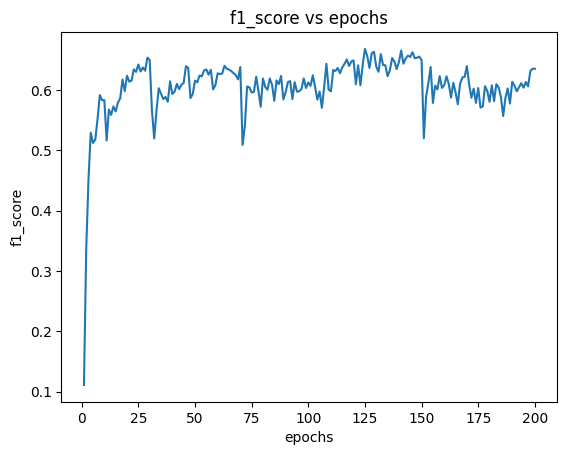

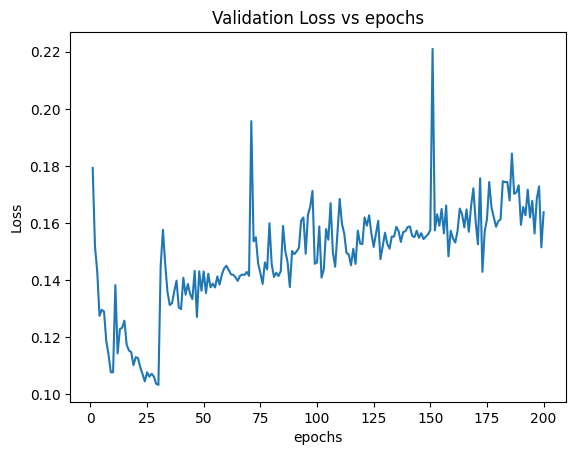

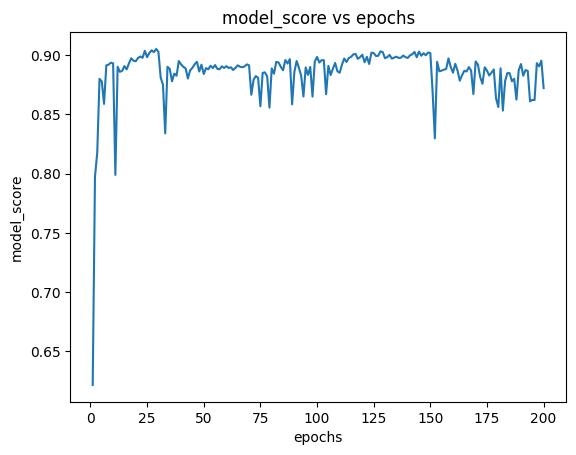

In [7]:
K = len(f1_arr)+1
plt.figure(1)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,K), f1_arr)
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.title('f1_score vs epochs')

plt.figure(2)
#plt.plot(sorted(list(set(roc_epochs))), loss_arr)
plt.plot(range(1,K), loss_arr)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('Validation Loss vs epochs')

plt.figure(3)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,K), model_arr)
plt.xlabel("epochs")
plt.ylabel("model_score")
plt.title('model_score vs epochs')

print(max_ms)   

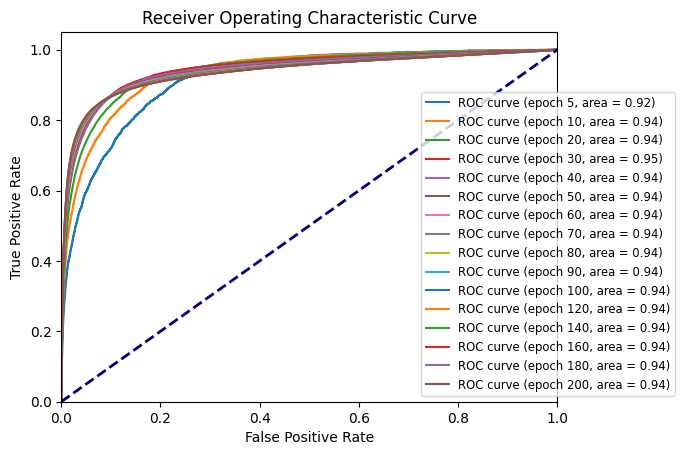

In [8]:
# plot ROC curve
fig2, ax2 = plt.subplots()
for i in range(len(roc_auc)):
    ax2.plot(roc_fpr[i], roc_tpr[i], label=f'ROC curve (epoch {roc_epochs[i]}, area = {roc_auc[i]:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic Curve')
# Set the properties for the legend
legend = ax2.legend(loc='lower right', bbox_to_anchor=(1.25, 0), fontsize='small', framealpha=0.8)